### This is a pipeline rundown of the Logical Flow of the code
#### Key Steps:
- Generate a Signal of Interest
- Define the Sensor of Interest
- Create the appropriate delay at each channel (and save the recording)
- Perform Beamforming on the Recording
- Plot the Power Beamformer

#### Create a Sinusoid Tone

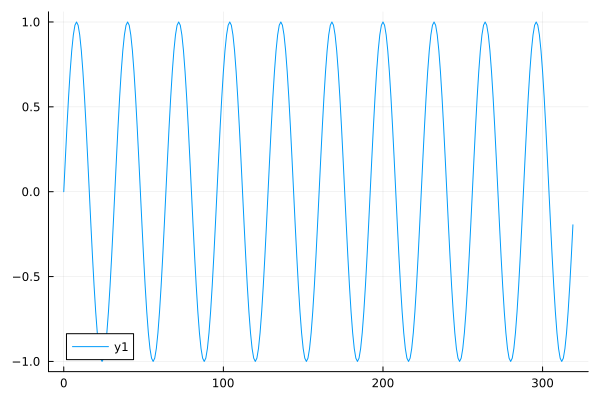

In [49]:
#=
We can Create a Sinusoid Tone
=#
function tone(duration=90, amp=1, f=1000, sample_rate=32000)
    # t = 0:duration;/
    n = 0:(duration.*sample_rate - 1);
    P = amp .* sin.(2 .* π .* f ./ sample_rate .* n);
    P = mapreduce(permutedims, vcat, [P']);
    return P, n
end

freq = 1000;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

using Plots
plot(n[1:320], tone_sig[1:320]) # Plot 1st 32000 samples (1s)

sensors Loaded: (8,)


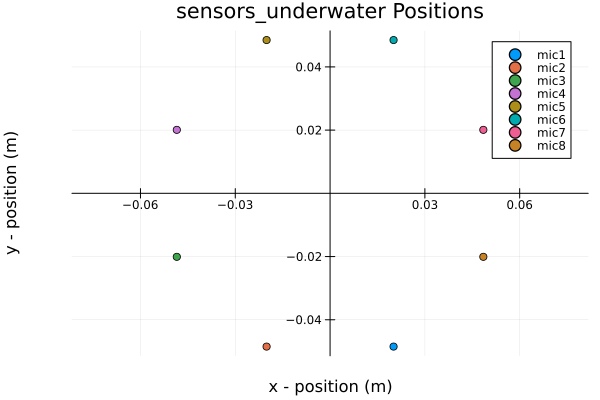

In [4]:
#=
Sensor Positions for Matrix Creator
    [x, y, z] - Coordinate
=#
mic1 = [0.02009, -0.0485, 0]
mic2 = [-0.02009, -0.0485, 0]
mic3 = [-0.0485, -0.02009, 0]
mic4 = [-0.0485, 0.02009, 0]
mic5 = [-0.02009, 0.0485, 0]
mic6 = [0.02009, 0.0485, 0]
mic7 = [0.0485, 0.02009, 0]
mic8 = [0.0485, -0.02009, 0]

sensors = [mic1, mic2, mic3, mic4, mic5, mic6, mic7, mic8]; 
println("sensors Loaded: $(size(sensors))")

using Plots
p = plot();
for (idx, mic) in enumerate(sensors)
    p = plot!([mic[1]], [mic[2]], st=:scatter, label="mic$(idx)",
            framestyle=:origin,
            aspect_ratio=:equal)
end
xlabel!("x - position (m)")
ylabel!("y - position (m)")
title!("sensors_underwater Positions")

# This can be summarized in the following code:
# include("./sensor.jl")

#### This is how to calculate the delays imposed on each sensor

In [136]:
using LinearAlgebra: ⋅ # Dot Product Operation
#=
az: Azimuth Angle in degrees
el: Elevation Angle in degrees
=#
function spherical_to_cartesian(az::Real, el::Real)
    u = cosd(az) .* sind(el);
    v = sind(az) .* sind(el);
    w = cosd(el) ;

    r = [u, v, w];
    return r;
end

#=
Generates Time Delay based on Far-field Planar Wave
with respect to the sensor's position
Input:
sensor_pos  : Sensor Position [x, y, z] in meters
az          : Azimuth Angle (in degrees)
el          : Elevation Angle (in degrees)
c0          : Speed of Wave (m/s)

Output:
time_delay  : Time Delay of Signal at the specified sensor
=#
function generate_time_delay(sensor_pos::Vector, az::Real, el::Real, c0::Real)
    r = spherical_to_cartesian(az, el);
    time_delay = -1* (sensor_pos ⋅ r)/ c0;

    return time_delay
end

#=
Suppose our Angle of Arrival is at 90 degrees
=#
az_gt = 90; # Degrees
c0 = 343;   # Speed of Medium (m/s)
d = generate_time_delay.(sensors, az_gt, 90, c0)
for (idx, τ) in enumerate(d)
    println("The Time Delay on mic$(idx) located at $(sensors[idx]) is $(τ) seconds")
end

#=
Recenter the delay such that its minimum is zero
=#
d .-= minimum(d)
println()
println("After Recentering: ")
for (idx, τ) in enumerate(d)
    println("The Time Delay on mic$(idx) located at $(sensors[idx]) is $(τ) seconds")
end
# Summarized in the following codes:
# include("./utils/coordinates.jl")
# include("./signal_generator/generate_sig.jl")

The Time Delay on mic1 located at [0.02009, -0.0485, 0.0] is 0.000141399416909621 seconds
The Time Delay on mic2 located at [-0.02009, -0.0485, 0.0] is 0.000141399416909621 seconds
The Time Delay on mic3 located at [-0.0485, -0.02009, 0.0] is 5.8571428571428575e-5 seconds
The Time Delay on mic4 located at [-0.0485, 0.02009, 0.0] is -5.8571428571428575e-5 seconds
The Time Delay on mic5 located at [-0.02009, 0.0485, 0.0] is -0.000141399416909621 seconds
The Time Delay on mic6 located at [0.02009, 0.0485, 0.0] is -0.000141399416909621 seconds
The Time Delay on mic7 located at [0.0485, 0.02009, 0.0] is -5.8571428571428575e-5 seconds
The Time Delay on mic8 located at [0.0485, -0.02009, 0.0] is 5.8571428571428575e-5 seconds

After Recentering: 
The Time Delay on mic1 located at [0.02009, -0.0485, 0.0] is 0.000282798833819242 seconds
The Time Delay on mic2 located at [-0.02009, -0.0485, 0.0] is 0.000282798833819242 seconds
The Time Delay on mic3 located at [-0.0485, -0.02009, 0.0] is 0.000199

In [182]:
1 / 8.28279e-5

12073.226533571418

In [137]:
#=
Some Helper Plot Function
=#
function check_delayed_signal(orig_sig, new_sig, delays, sample_rate=32000, num_period=40)
    d_max = num_period * Int(round(maximum(delays)*sample_rate));
    println("Value of d_max: $d_max")
    for (ch, sig) in enumerate(eachcol(new_sig))
        p = plot(orig_sig[1:d_max], label="Original Signal")
        plot!(sig[1:d_max], label="ch: $ch")
        xlabel!("Samples (n)")
        ylabel!("Amplitude")
        plot!([1; 1+round(delays[ch]*sample_rate)],[0;0], label="Delay")
        display(p)
    end
end

check_delayed_signal (generic function with 3 methods)

### Delaying a Signal thru the Frequency Domain
- 1st Methodology is simple FFT processing
- 2nd Methodology uses STFT and delays the signal at each time bin

Using FFT for Delaying


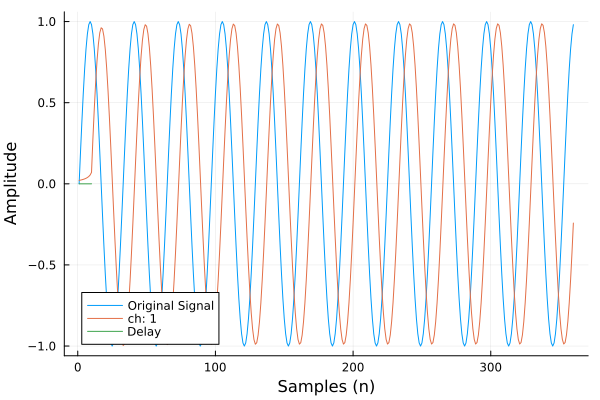

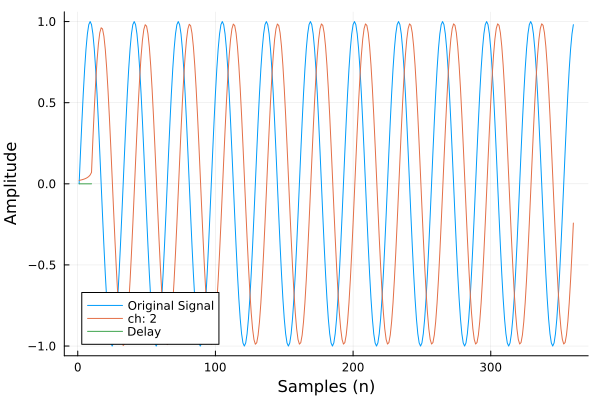

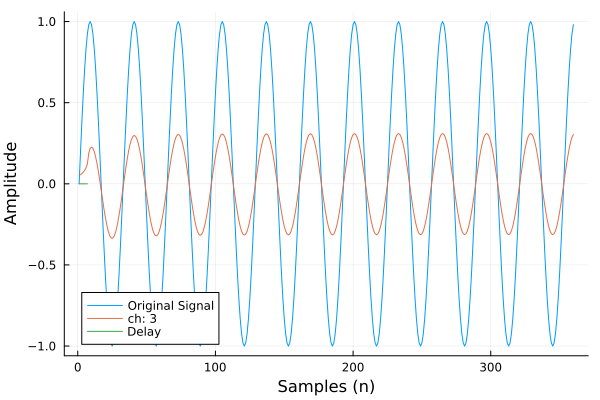

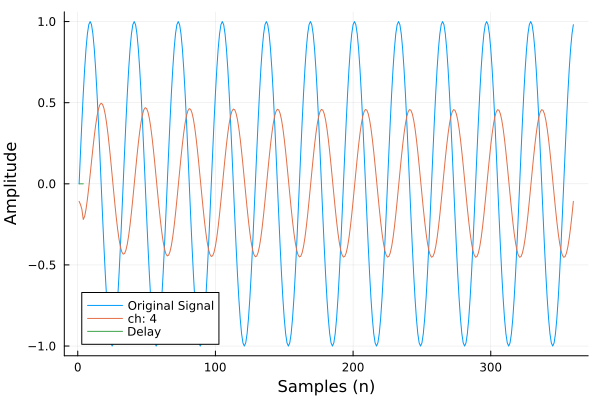

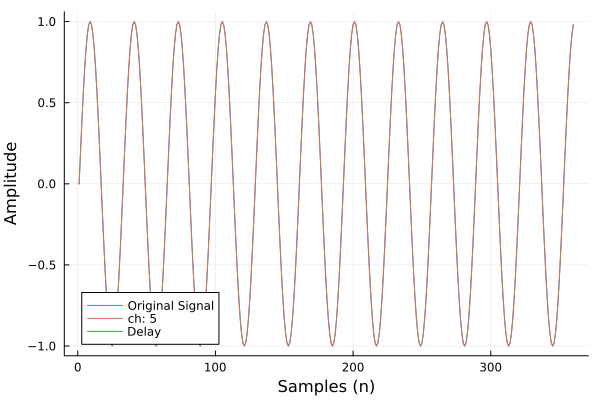

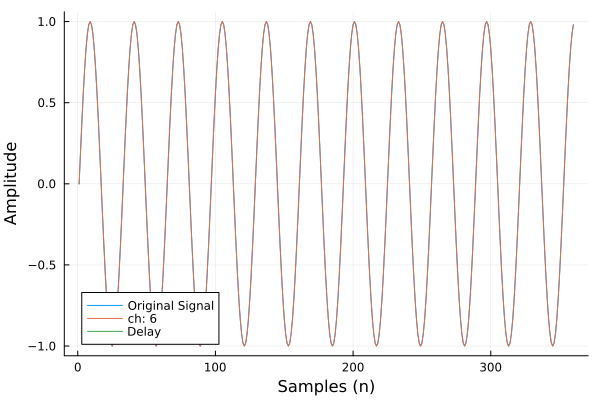

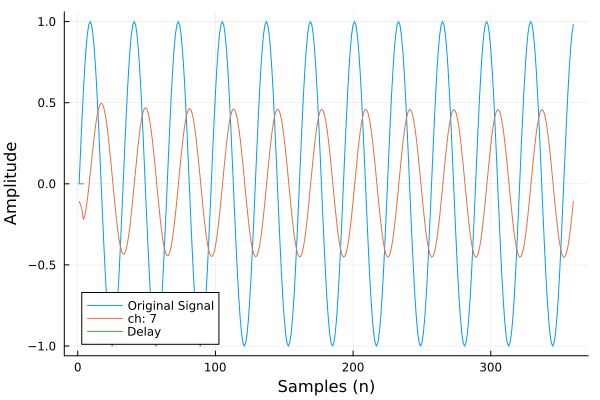

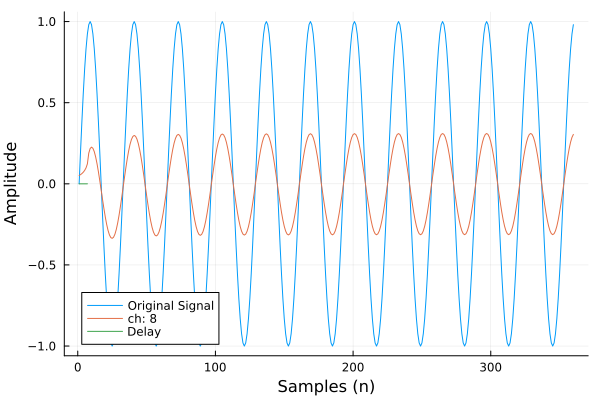

Value of d_max: 360


In [127]:
using FFTW
#=
delay_signal() delays the signal according to time delays in d
thru the frequency domain (might help for non-integerized delays)

Input:
signal      : Signal (num_samples * 1 Matrix)
d           : Delays for each sensor
fs          : Sampling Frequency of Signal (Hz)

Output:
new_sig     : Delayed Signal at respective channel/sensor
                (Matrix of size num_samples * num_sensors)
=#
function delay_signal_fft(signal::Matrix, d::Vector, fs)
    size(signal, 2) == 1 ? 1 : @error throw(
        DimensionMismatch("signal needs to be a num_samples * 1 matrix instead of $(size(sig))")) 

    println("Using FFT for Delaying")
    g(y, delay, freq) = y*exp(-1im*2*π*freq*delay);
    Y = fft(signal);
    Y = vec(Y);
    NFFT = length(Y);
    frequencies = fs/NFFT*(0:(NFFT-1));

    new_sig = Matrix{ComplexF64}(undef, size(Y,1), size(d,1))
    for (idx, delay) in enumerate(d)
            # append!(Y.*exp(-1im.*2.*π.*freq.*delay) );
            delayed = g.(Y, delay, frequencies);
            new_sig[:, idx] = ifft(delayed);
    end
    return new_sig
end

some_sig = delay_signal_fft(tone_sig, d, 32000);
check_delayed_signal(tone_sig, real(some_sig), d, 32000)

Now we can simulate the received signals at the sensors

In [140]:
#=
simulate_sensor_signal() simulates the received signal on the sensors
based on its expected time delay and sampling rate of the sensors.

Note: This processing is done in the Complex Domain,
    hence the multichannel signal cannot be saved as a WAV File

Input:
signal      : Matrix of size (# samples * 1 channel)
sample_rate : Sampling Rate of Signal
sensors     : Vector (size: # of sensors) containing
                Sensor Positions (# of coordinates = 3)
az_gt       : Azimuth Angle to simulate (in Degrees)
c0          : Speed of Medium (in m/s)

Output:
new_sig     : Delayed Signals according to sensors' positions
sample_rate : Sampling Rate of Signal (in Hz)
az_gt       : Simulated Azimuth Angle (in Degrees)
=#
function simulate_sensor_signal(signal::Matrix, sample_rate::AbstractFloat, sensors::Vector, 
    az_gt = 0.0, c0 = 343.0)

    #= 
    Step 1: Generate delays based on sensor positions
    =#
    println("Start Simulating Signal")
    # az_gt = 0; # Ground Truth of Azimuth Angle
    d = generate_time_delay.(sensors, az_gt, 90, c0)
    d .-= minimum(d) # Make all delays positive
    # println("Delays for each sensor: ", d)

    #= 
    Step 2: Simulate Wave Sample by creating multichannel
    sample with respective delays
    =#
    start_idx = Int(sample_rate);
    println("Signal has size: $(size(signal))")
    mod_signal = signal;
    mod_signal[start_idx:end, :] .= 0; # Only taking 1 second of Signal
    @time new_sig = delay_signal_fft(mod_signal, d, sample_rate);
    println("Now Generated Signal has size: $(size(new_sig))")

    return new_sig, sample_rate
end

az_gt1 = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;     # Ground Truth Azimuth Angle (in degrees)

sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors,
                        az_gt1, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, 
                        az_gt2, c0); 
new_sig = sig1 + sig2;

Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.141182 seconds (286 allocations: 126.970 MiB)
Now Generated Signal has size: (320000, 8)
Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.174429 seconds (286 allocations: 126.970 MiB, 15.31% gc time)
Now Generated Signal has size: (320000, 8)


#### Building a Delay-and-Sum (DS)/ Conventional Beamformer
Here we create a simple Delay-and-Sum Beamformer

### Perform Conventional Beamforming:
Now we form the conventional Beamformer thru the following framework:

$P(\theta_{S}) = | B[\vec{h}(\omega, \theta_{S}), \theta] |^{2} = \vec{h}^{H}(\omega, \theta_{S}) \mathbf{R_{Y}} \vec{h}(\omega, \theta_{S})$

In [141]:
#=
Input:
sensor_pos  : Sensor Position [x, y, z] in meters
az          : Azimuth Angle (in degrees)
el          : Elevation Angle (in degrees)
f           : Frequency (in Hz)
c0          : Speed of Medium (in m/S)

Output:
weight      : Delay coefficient
=#
function vandermonde_weight(sensor_pos, az, el, f=1000, c0=343)
    ω = 2 * π * f;
    τ = generate_time_delay(sensor_pos, az, el, c0)
    weight = exp.(-1im * ω * τ)
    # println("Weights size: ", size(weights))

    return weight 
end

#=
Input:
Rx          : Covariance Matrix of Signal
sensors     : Sensor Positions corresponding to Rx
f           : Frequency (in Hz)
c0          : Speed of Medium (in m/S)

Output:
p           : Power of Beampattern
az_list     : List Containing Azimuth Angles
=#
function cbf(Rx, sensors, f=1000, c0=343)
    az_list = LinRange(-180,180,361);
    P = Vector{}(undef, size(az_list,1));
    for (idx, az) in enumerate(az_list)
        weights = vandermonde_weight.(sensors, az, 90, f, c0);
        P[idx] = weights' * Rx * weights;
    end
    return abs.(P), az_list;
end

cbf (generic function with 3 methods)

In [143]:
function normalize_P(P, az_list) 
    (P_max, max_idx) = findmax(P);
    return (P ./ P_max), az_list[max_idx]
end

normalize_P (generic function with 1 method)

### Performing a "Single-Snapshot" Beamformer

In [159]:
#= 
Step 1: Pre-process Signal by selecting 
        Frequency of Interest at each channel
        (FFT instead of STFT)
=#
function filter_freq_per_ch(new_sig, freq_interest, sample_rate)
    new_S = []
    NFFT = size(new_sig, 1);
    frequencies = sample_rate/NFFT*(0:(NFFT-1));
    (_, freq_idx) = findmin( abs.(frequencies .- freq_interest) );

    for signal in eachcol(new_sig)
        S_interest = fft(signal);
        S_interest = S_interest[freq_idx];
        push!(new_S, S_interest);
    end

    return new_S
end

new_S = filter_freq_per_ch(new_sig, freq, sample_rate);
new_S1 = filter_freq_per_ch(sig1, freq, sample_rate);
new_S2 = filter_freq_per_ch(sig2, freq, sample_rate);

#=
Calculate Correlation Matrix
=#
Rx = (1 ./ 1) .* new_S * new_S';
Rx1 = (1 ./ 1) .* new_S1 * new_S1';
Rx2 = (1 ./ 1) .* new_S2 * new_S2';

@time P_cbf, az_list = cbf(Rx, sensors, freq, c0);
@time P1_cbf, az_list = cbf(Rx1, sensors, freq, c0)
@time P2_cbf, az_list = cbf(Rx2, sensors, freq, c0)

P_cbf_norm, az_cbf_max = normalize_P(P_cbf, az_list)
P1_cbf_norm, az1_cbf_max = normalize_P(P1_cbf, az_list)
P2_cbf_norm, az2_cbf_max = normalize_P(P2_cbf, az_list)


  0.000589 seconds (4.35 k allocations: 384.562 KiB)
  0.000578 seconds (4.35 k allocations: 384.562 KiB)
  0.000628 seconds (4.35 k allocations: 384.562 KiB)


([0.6112649717974196, 0.6015604509581421, 0.5918759161058741, 0.58221661121236, 0.5725876495329131, 0.5629940102207672, 0.5534405352332257, 0.5439319265286635, 0.5344727435528062, 0.5250674010120948  …  0.6985802998632197, 0.6889514021196551, 0.6792901146450384, 0.6696026577603018, 0.6598951644910652, 0.6501736746264184, 0.6404441290467369, 0.6307123643259929, 0.6209841076132668, 0.6112649717974196], 120.0)

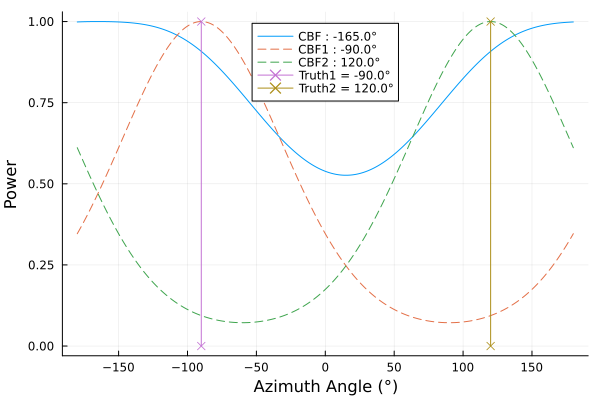

In [168]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power")
plot!(az_list, P1_cbf_norm, label="CBF1 : $(az1_cbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_cbf_norm, label="CBF2 : $(az2_cbf_max)°",
    linestyle=:dash);
plot!([az_gt1; az_gt1], [0; 1], marker=:x, label="Truth1 = $(az_gt1)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°", legend=:top)

### Differential Beamforming
We are going to create the following Matrices to build a filter $\vec{h}(\omega)$ that represents the Differential Beamformer

$\mathbf{\Psi}(\omega) \vec{h}(\omega) = \mathbf{\Upsilon}^{*}(\theta_{S}) \vec{v}_{2N}$

In [161]:
#=
Some misc functions to help us calculate the matrices
=#

#=
Convert Cartesian Coordinates to Polar Coordinates

Input:
xy      : [x, y, z] coordinate

Output:
[r, az] : Radius, Azimuth Angle (in radians)
=#
function cartesian_to_polar(xy::Vector)
    r = xy[1]^2 + xy[2]^2 + xy[3]^2;
    az = atan(xy[2], xy[1]);
    # el = acosd(xy); # Still need some thought process
    return [sqrt(r), az];
end

#=
Convert Sensors' positions from cartesian coordinate to polar

Input:
sensors : Vector (size: # of sensors) containing
             sensor positions (3 - coordinates: [x, y. z])

Output:
polar_sensor    : Vector (size: # of sensors) containing
             sensor positions (2 - coordinates: [r, az (in degrees)])
=#
function sensors_in_polar(sensors::Vector)
    polar_sensor = [];
    for sensor in sensors
        polar = cartesian_to_polar(sensor)
        push!(polar_sensor, polar)
    end
    return polar_sensor
end

sensors_in_polar (generic function with 1 method)

First to create the Matrix $\mathbf{\Psi}(\omega)$ where it is defined as the following:

$\vec{\psi}_{n}(\omega) = \begin{bmatrix} \vdots \\ J_{n}(\frac{\omega r_{m}}{c_{0}}) e^{-jn \psi_{m}}\\ \vdots \end{bmatrix} \in \mathbb{C}^{M}$

$\mathbf{\Psi}(\omega) = \begin{bmatrix} \vdots \\ (-j)^{n}\vec{\psi}^{H}_{n} (\omega) \\ \vdots \end{bmatrix} \in \mathbb{C}^{2N \times M}$ with $n \in \{-N, ..., N\}$ 

In [162]:
using SpecialFunctions: besselj
using LinearAlgebra
#=
Compute the individual ψ entry 

Input:
r       : Radius of sensor position from origin
az      : Azimuth Angle of sensor position from x-axis origin
order   : Order of Bessel Function
=#
function ψ(r::Real, az::Real, order::Int, f=1000, c0=343)
    ω = 2 * π * f;
    # println("Order: $order")
    return besselj(order, ω*r/c0) * exp(-1im * order * az)
end

#=
Generate the ψ matrix for Differential Beamforming

Inputs:
sensors : Vector (size: # of sensors) containing
             sensor positions (3 - coordinates: [x, y. z])
order   : Order of Differential Beamformer
f       : Frequnecy of Interest (in Hz)
c0      : Speed of Medium (in m/s)

Output:
ψ_mat   : ψ Matrix
=#
function create_ψ_matrix(sensors::Vector, order=3, f=1000, c0=343)
    polar_sensor = sensors_in_polar(sensors);
    ψ_mat = Matrix{ComplexF64}(undef, 2*order+1, size(polar_sensor,1));
    for (idx, n) in enumerate(-1*order:1:order)
        ψ_vec_n = [];
        for sensor in polar_sensor # [r, az] - coordinates
            value =  ψ(sensor[1], sensor[2], n, f, c0);
            append!(ψ_vec_n, value)
        end
        # println("ψ_vec_n = $(ψ_vec_n)")
        # println(" and its transpose: $(ψ_vec_n')")
        ψ_mat[idx, :] = ( (-1.0im)^n ) .* ψ_vec_n'; # ' only transposes
    end
    return ψ_mat
end

create_ψ_matrix (generic function with 4 methods)

Now to create the Matrix $\mathbf{\Upsilon}(\theta_{S})$ defined as follows:

$\mathbf{\Upsilon}(\theta_{S}) = \begin{bmatrix} \ddots & & \\ & e^{-jn\theta_{S}} & \\ & & \ddots \end{bmatrix} \in \mathbb{C}^{2N \times 2N}$ is a diagonal matrix with $n \in \{-N, ..., N\}$ 

In [163]:
#=
Generate the Steering Matrix to be paired with ψ for DBF

Inputs:
az_steer_deg    : Azimuth Steering Angle (in degrees)
order           : Order of Differential Beamformer

Output:
γ               : Steering Matrix
=#
function steering_matrix(az_steer_deg, order)
    n = -1*order:1:order;
    az_steer = deg2rad(az_steer_deg);
    γ = Diagonal(exp.(-1im .* n .* az_steer));

    # Alternative
    # az_steer = az_steer_deg ./ 180 .* π;
    # γ = Diagonal(exp.(-1im .* n .*  az_steer_deg ./ 180 .* π));
    return γ
end

steering_matrix (generic function with 1 method)

Now we can create the differential beamforming formulation where the solution of $\vec{h}(\omega)$ is:

$\vec{h}(\omega, \theta_{S}) = \Psi^{H}(\omega) \text{  } (\Psi(\omega)\Psi^{H}(\omega))^{-1} \text{  } \Upsilon(\theta_{S}) \vec{v}_{2N}$

In [169]:
#=
dbf_coFree() creates the Differential Beamformer (coordinate-free)
based on the Correlation Matrix Rx and sensors' positions

Input:
Rx          : Covariance Matrix of Signal
sensors     : Sensor Positions corresponding to Rx

Output:
P           : Power of Beampattern
az_list     : List Containing Azimuth Angles (in degrees)
=#
function dbf_coFree(Rx::Matrix, sensors::Vector, order=3, f=1000, c0=343)
    # Creates 1st Order Cardioid, 2nd or 3rd -Order Hypercardioid
    v = ones(Rational, 2*order+1); # Weights associated with DBF
    v .//= size(v,1);
    # v = [1//2, 0//2, 1//2];

    println("weighting vector: $v has sum $(sum(v))")
    ψ = create_ψ_matrix(sensors, order, f, c0);
    println("ψ has rank $(rank(ψ))")
    sensor_term = ψ' * inv( ψ * ψ' ); ### To be substituted for h_dbf

    az_list = LinRange(-180,180,361);
    P = Vector{}(undef, size(az_list,1));
    h_filter = Vector{}(undef, size(az_list,1))
    for (idx, az) in enumerate(az_list)
        γ = steering_matrix(az, order);
        h_dbf = sensor_term * conj(γ) * v; ### Create the solution of the filter
        P[idx] = h_dbf' * Rx * h_dbf;
        h_filter[idx] = h_dbf;
    end
    return abs.(P), az_list, ψ, h_filter;
end

# For more info, can refer to:
# include("./doa/dbf_coFree.jl")

dbf_coFree (generic function with 4 methods)

Perform Differential Beamforming onto the Data

In [165]:
order = 3;
@time P_dbf, az_list = dbf_coFree(Rx, sensors, order, freq, c0)
@time P1_dbf, az_list = dbf_coFree(Rx1, sensors, order, freq, c0)
@time P2_dbf, az_list = dbf_coFree(Rx2, sensors, order, freq, c0)

P_dbf_norm, az_dbf_max = normalize_P(P_dbf, az_list)
P1_dbf_norm, az1_dbf_max = normalize_P(P1_dbf, az_list)
P2_dbf_norm, az2_dbf_max = normalize_P(P2_dbf, az_list)

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.129661 seconds (205.46 k allocations: 10.597 MiB, 99.07% compilation time)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001038 seconds (11.53 k allocations: 684.367 KiB)


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001119 seconds (11.57 k allocations: 689.133 KiB)


([0.02000876121394124, 0.02375457997110415, 0.02751497128987569, 0.03122185237235653, 0.034812422544630295, 0.0382295369924924, 0.041422012420509795, 0.04434486341648307, 0.04695946902208028, 0.049233669721923966  …  0.0001319731986945876, 7.578316876874432e-5, 0.0007929181040789759, 0.002194305346366571, 0.004190270933851627, 0.006691358617803336, 0.009609121636182274, 0.012856880444734898, 0.016350440064004063, 0.020008761213941326], 120.0)

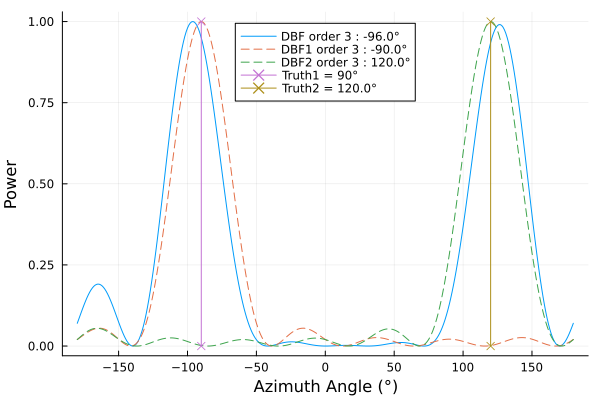

In [167]:
plot(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_dbf_norm, label="DBF1 order $order : $(az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_dbf_norm, label="DBF2 order $order : $(az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt1; az_gt1], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°", legend=:top)

### Multi-Snapshot Beamforming

### Some Windows to play with

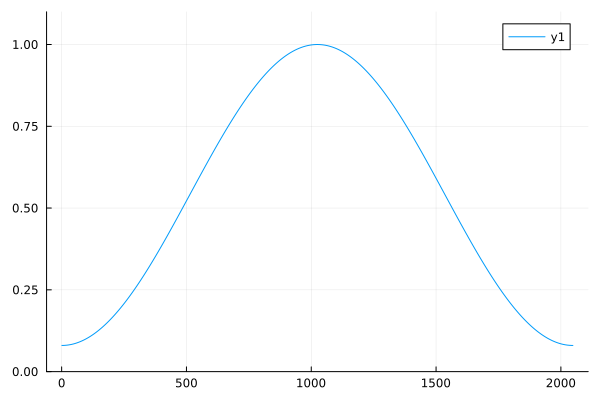

In [70]:
using DSP: rect, hamming, hanning
NFFT = 2^11;
noverlap = 2^10;
plot(hamming(NFFT))
ylims!((0, 1.1))

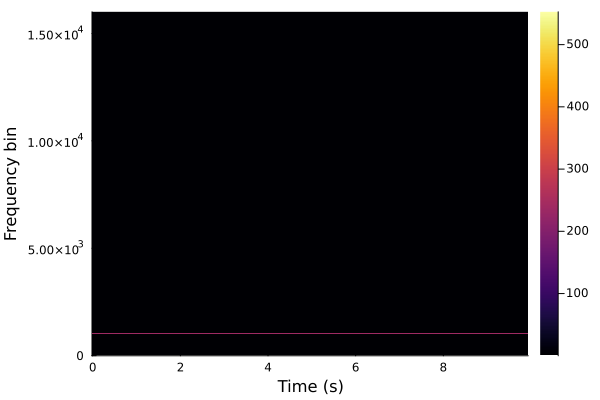

In [74]:
using FFTW

function stft(x, win::Vector, noverlap::Int, fftsize::Int)
    # x: input signal
    # win: window function
    # noverlap: number of overlapping signals 
    # fftsize: FFT size (in samples)
    
    hop = length(win) - noverlap; # hop size (in samples)
    # Calculate the number of frames in the STFT
    n_frames = 1 + (length(x) - fftsize) ÷ hop
    # println("n_frames = $n_frames")
    
    # Pre-allocate the STFT matrix
    X = zeros(ComplexF64, fftsize ÷ 2 + 1, n_frames)
    
    # Apply the window function to the input signal
    # x_win = x .* win
    
    # Compute the STFT frame by frame
    for i in 1:n_frames
        # Get the current frame
        start_idx = (i - 1) * hop + 1
        end_idx = start_idx + fftsize - 1
        x_frame = x[start_idx:end_idx] .* win
        # println("x_frame @ $i: $(size(x_frame))")

        if length(x_frame) < fftsize
            # println("Prev x_frame length : $(length(x_frame))")
            x_frame = append!(x_frame, zeros(fftsize - length(x_frame)))
            # println("Modified for FFT: $(length(x_frames))")
        end
        
        # Compute the FFT of the current frame
        X_frame = fft(x_frame)
        # println("X_frame -> $(size(X_frame))")
        
        # Store the first-half of the spectrum of the current frame in the STFT matrix
        X[:, i] = X_frame[1:fftsize ÷ 2 + 1]
    end
    
    return X
end

# Overload the function based on the input type
function stft(x, win::Vector, noverlap::Int, fftsize::Int, sample_rate::AbstractFloat)
    hop = length(win) - noverlap;
    X = stft(x, win, noverlap, fftsize);
    n_frames = 1 + (length(x) - fftsize) ÷ hop

    # Calculate the time and frequency vectors
    frame_rate = sample_rate / hop
    frame_duration = hop / sample_rate
    times = frame_duration * (0:n_frames-1)
    frequencies = LinRange(0, sample_rate/2, fftsize ÷ 2 + 1)
    
    return X, frequencies, times
end

# Compute the STFT of the input signal
X = stft(tone_sig, hamming(NFFT), noverlap, NFFT)
X, frequencies, times = stft(tone_sig, hamming(NFFT), noverlap, NFFT, sample_rate)

# Plot the magnitude spectrogram of the STFT
using Plots
heatmap(times, frequencies, abs.(X), xlabel="Time (s)", ylabel="Frequency bin")

In [80]:
# Using Overlap-Add Method
function istft(X, win, noverlap)
    # X: STFT matrix
    # win: window function
    # noverlap: Number of Overlapping Samples during stride
    
    hop = length(win) - noverlap; # hop: hop size (in samples)
    
    # Get the number of FFT points and frames from the STFT matrix shape
    fftsize, n_frames = size(X)
    fftsize = (fftsize - 1) * 2; # Since only looking at postive frequencies during STFT
    
    # Pre-allocate the output signal
    n_samples = (n_frames - 1) * hop + fftsize
    x_recon = zeros(n_samples)
    
    # Apply the window function to the FFT frames and compute the iFFT
    for i in 1:n_frames
        # Compute the iFFT of the current frame
        x_frame = real(ifft([X[:, i]; conj(reverse(X[2:end-1, i]))]))
        # println(size(x_frame))
        
        # Apply the window function to the time-domain frame
        start_idx = (i - 1) * hop + 1
        end_idx = start_idx + fftsize - 1
        # println(fftsize)
        # println("$start_idx $end_idx $(end_idx-start_idx)")
        x_recon[start_idx:end_idx] += x_frame .* win
    end
    
    return x_recon
end

istft (generic function with 1 method)

Using STFT w/ NFFT=2048 & noverlap=1024


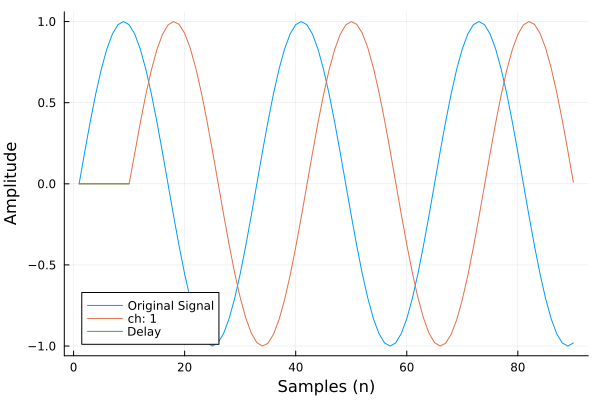

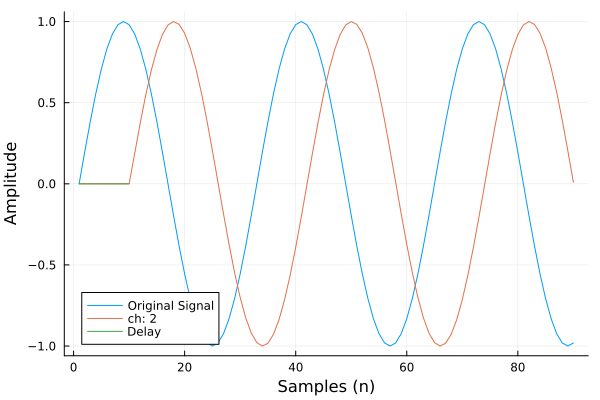

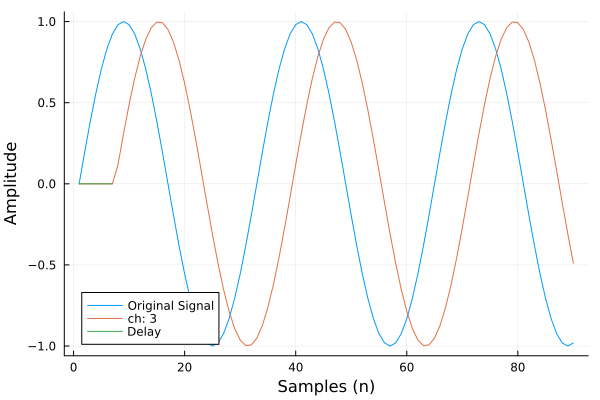

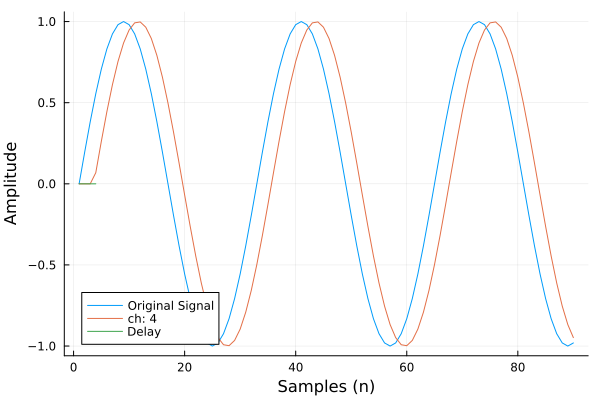

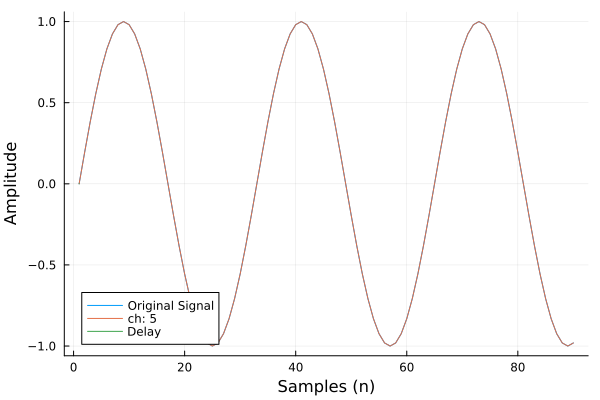

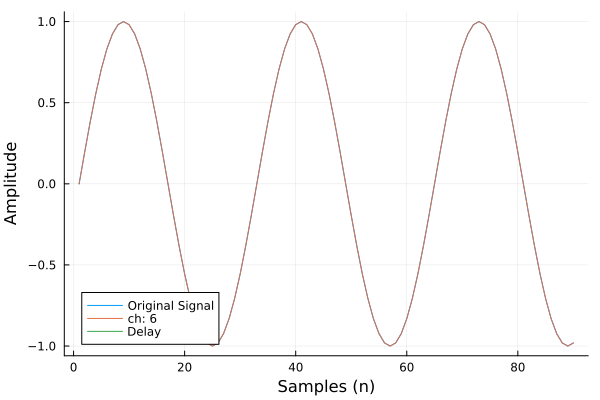

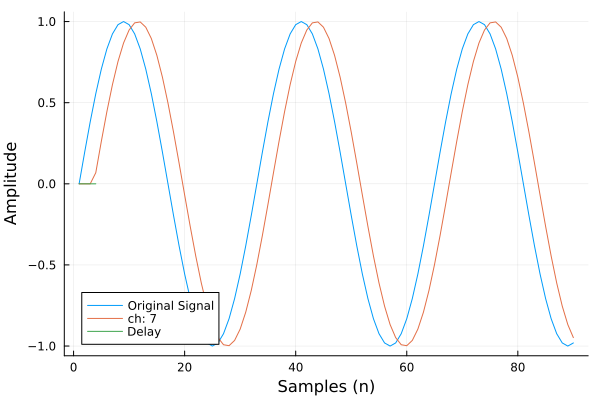

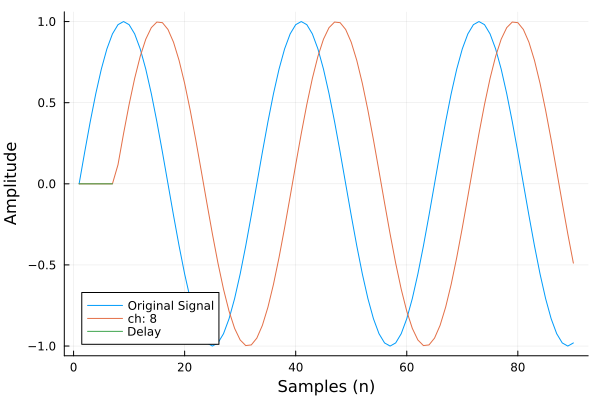

Value of d_max: 90


In [89]:
using DSP: rect, hanning, hamming
#=
Input:
signal          : Single Channel Signal
fs              : Sampling Rate of Signal (in Hz)
win_size        : Size of Window for STFT
noverlap        : Number of Samples Overlapping
window          : Window Function (Refer to DSP.Windows -> Note 2)

Output:
S               : STFT (Complex Matrix: # frequencies * # strided samples)
frequencies     : Vector containing Frequencies (given Sampling Rate fs)
times           : Vector containing timestamp (given fs, window & noverlap)

Note: For speech processing, get NFFT coressponding to 23ms (512 for fs:22.050kHz)
Note 2: https://docs.juliadsp.org/stable/windows/

Guide to window size & noverlap: 
https://www.dsprelated.com/freebooks/sasp/Choice_Hop_Size.html
=#
# function generate_STFT(signal, fs=32000, win_size::Int=2^11,
#     noverlap::Int=Int(window * (3//4)), window::Function=DSP.Windows.hanning)
#    S = spectrogram(signal, win_size, noverlap; fs=fs)
#    frequencies = DSP.Periodograms.freq(S);
#    times = DSP.Periodograms.time(S)
#    # (_, freq_idx) = findmin( abs.(frequencies .- freq_interest) )
#    S = stft(signal, win_size, noverlap; fs=fs, window=window)

#    # return S[freq_idx, :]
#    return S, frequencies, times
# end

#=
delay_signal() delays the signal according to time delays in d
thru the frequency domain (might help for non-integerized delays)

Input:
signal      : Signal (num_samples * 1 Matrix)
delays      : Delays for each sensor
fs          : Sampling Frequency of Signal (Hz)
NFFT        : (= Window Size) Number of FFT Points to take
noverlap    : Number of samples overlapping during STFT stride
window      : (A Function) Window function before taking individual FFT

Output:
new_sig     : Delayed Signal at respective channel/sensor
                (Matrix of size num_samples * num_sensors)

For window function, refer to https://docs.juliadsp.org/stable/windows/

Guide to window size & noverlap: 
https://www.dsprelated.com/freebooks/sasp/Choice_Hop_Size.html
=#
function delay_signal_stft(sig, delays::Vector, fs::AbstractFloat, 
    NFFT::Int=2^11, noverlap::Int=Int(NFFT * (3//4)), window=hanning)
    size(sig, 2) == 1 ? 1 : @error throw(DimensionMismatch("signal needs to be a num_samples * 1 matrix instead of $(size(sig))")) 

    println("Using STFT w/ NFFT=$(NFFT) & noverlap=$(noverlap)")
    # STFT of mono channel & prepare multichannel signal
    g(y, delay, freq) = y*exp(-1im*2*π*freq*delay);
    new_sig = zeros( size(sig,1), size(delays,1)); # num_samples * num_ch
    # S, frequencies, times = generate_STFT(sig[:,1], sample_rate, NFFT, noverlap); # Old Techinique
    S, frequencies, times = stft(sig[:,1], window(NFFT), noverlap, NFFT, fs)

    # Delay each channel with respective delays in frequency domain,
    # followed by inv-STFT of each channel.
    for (ch, delay) in enumerate(delays)
        new_stft = Matrix{ComplexF64}(undef, size(S,1), size(S,2));
        for (time_idx, ffts) in enumerate(eachcol(S))
            delayed = g.(ffts, delay, frequencies);
            new_stft[:, time_idx] = delayed;
        end
        # new_signal = istft(Real, new_stft; nfft=NFFT, noverlap=noverlap, window=window); # Old Technique
        new_signal = istft(new_stft, window(NFFT), noverlap);
        new_sig[1:length(new_signal), ch] = new_signal;
        delay_int = Int(ceil(sample_rate*delay));
        new_sig[1:delay_int, ch] .= 0; # Assume no signal for causality reasons
    end

    return new_sig
end

# Using Rectangular Window for Perfect Reconstruction (No-overlap for now)
new_sig = delay_signal_stft(tone_sig, d, sample_rate, NFFT, Int(NFFT//2), rect);
check_delayed_signal(tone_sig, real(new_sig), d, sample_rate, 10);

### Simulate Sensor Signal
Now we can define it as a function for multiple incoming wave

In [135]:


#=
simulate_sensor_signal() simulates the received signal on the sensors
based on its expected time delay and sampling rate of the sensors.

Note: This processing is done in the Complex Domain,
hence the multichannel signal cannot be saved as a WAV File

Input:
signal      : Matrix of size (# samples * 1 channel)
sample_rate : Sampling Rate of Signal
sensors     : Vector (size: # of sensors) containing
Sensor Positions (# of coordinates = 3)
az_gt       : Azimuth Angle to simulate (in Degrees)
c0          : Speed of Medium (in m/s)

Output:
new_sig     : Delayed Signals according to sensors' positions
sample_rate : Sampling Rate of Signal (in Hz)
az_gt       : Simulated Azimuth Angle (in Degrees)
=#
function simulate_sensor_signal(signal::Matrix, sample_rate::AbstractFloat, sensors::Vector, 
NFFT::Int, noverlap::Int, window::Function=hanning,
az_gt = 0.0, c0 = 343.0)

    #= 
    Step 1: Generate delays based on sensor positions
    =#
    println("Start Simulating Signal")
    # az_gt = 0; # Ground Truth of Azimuth Angle
    delays = generate_time_delay.(sensors, az_gt, 90, c0)
    delays .-= minimum(delays) # Make all delays positive
    # println("Delays for each sensor: ", d)

    #= 
    Step 2: Simulate Wave Sample by creating multichannel
    sample with respective delays
    =#
    println("Signal has size: $(size(signal))")
    @time new_sig = delay_signal_stft(signal, delays, sample_rate, NFFT, noverlap, window);
    println("Now Generated Signal has size: $(size(new_sig))")

    return new_sig, sample_rate
end

# This can be summarized under the following code:
# include("./signal_generator/generate_sig.jl")

az_gt1 = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;     # Ground Truth Azimuth Angle (in degrees)

sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors,
                         NFFT, noverlap, rect, az_gt1, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, 
                        NFFT, noverlap, rect, az_gt2, c0); 
new_sig = sig1 + sig2;

Start Simulating Signal
Signal has size: (320000, 1)
Using STFT w/ NFFT=2048 & noverlap=1024


  0.345616 seconds (109.90 k allocations: 632.506 MiB, 32.07% gc time)
Now Generated Signal has size: (320000, 8)
Start Simulating Signal
Signal has size: (320000, 1)
Using STFT w/ NFFT=2048 & noverlap=1024


  0.346269 seconds (109.90 k allocations: 632.506 MiB, 22.00% gc time)
Now Generated Signal has size: (320000, 8)


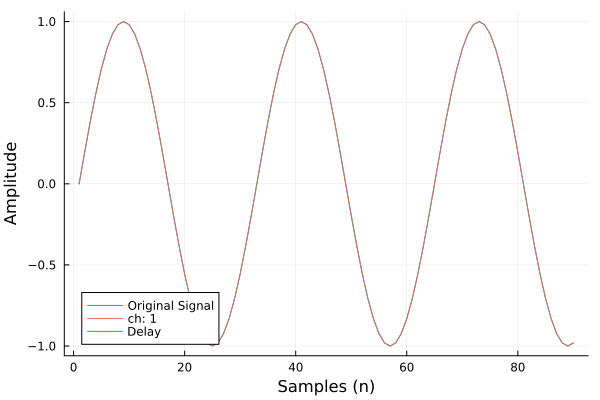

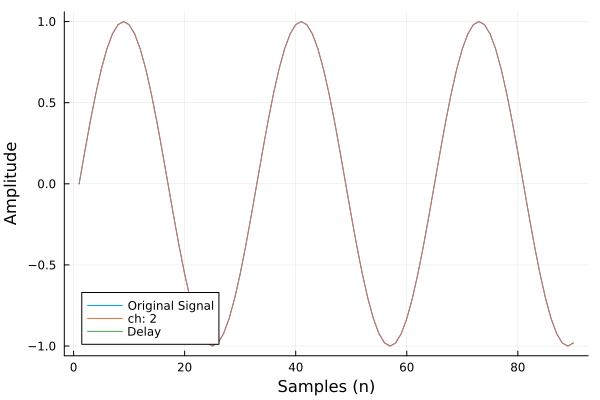

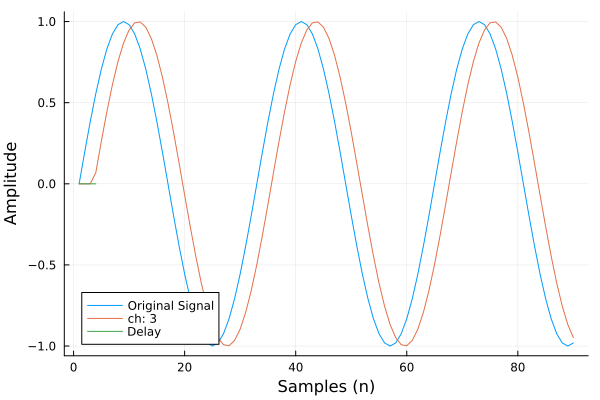

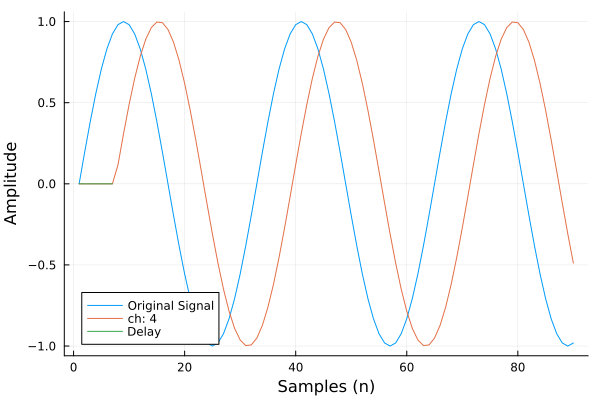

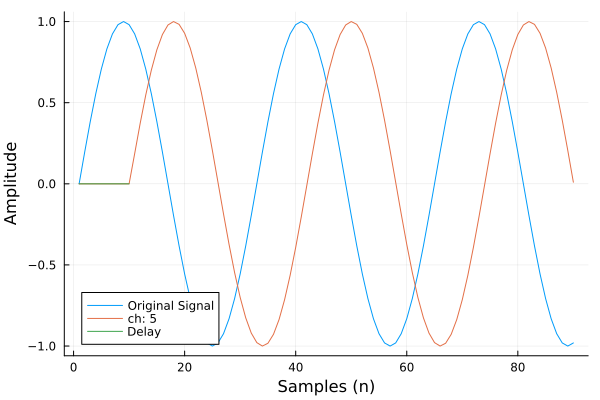

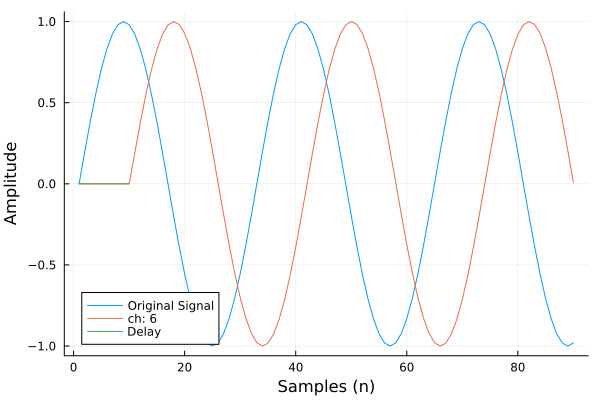

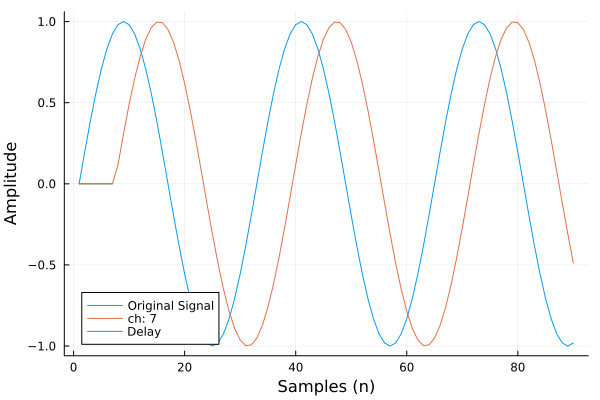

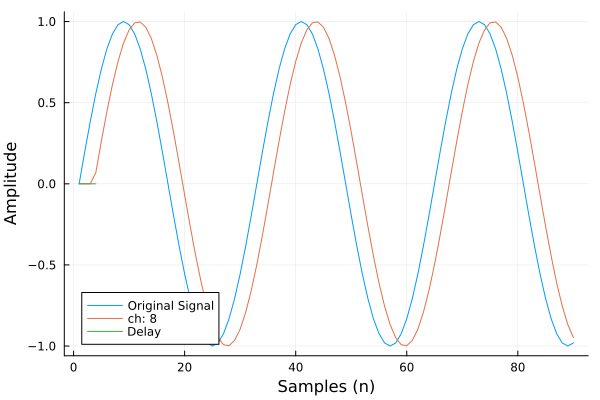

Value of d_max: 90


In [104]:
d1 = generate_time_delay.(sensors, az_gt, 90, c0)
d2 = generate_time_delay.(sensors, az_gt2, 90, c0)
d1 .-= minimum(d1);
d2 .-= minimum(d2);

check_delayed_signal(tone_sig, real(sig1), d1, sample_rate, 10);

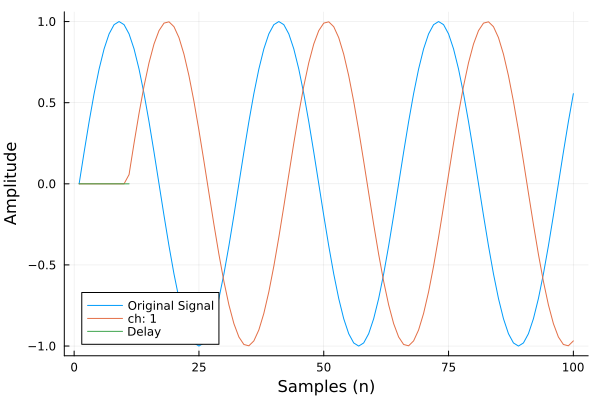

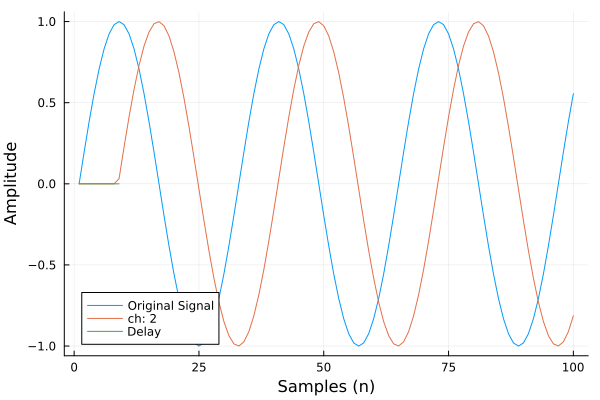

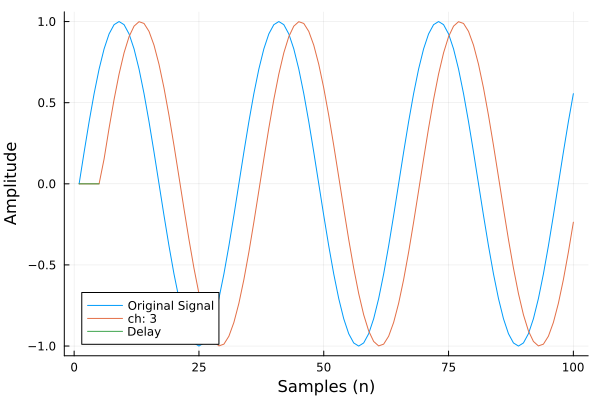

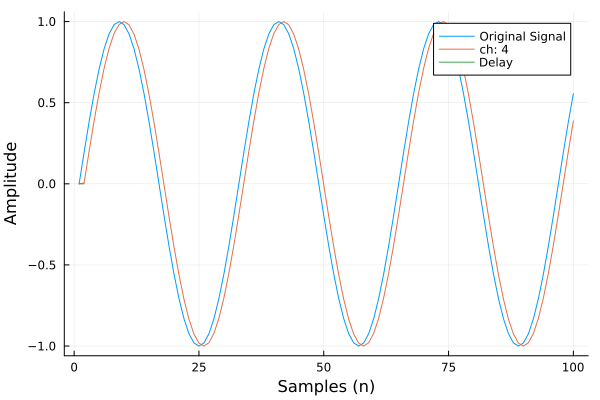

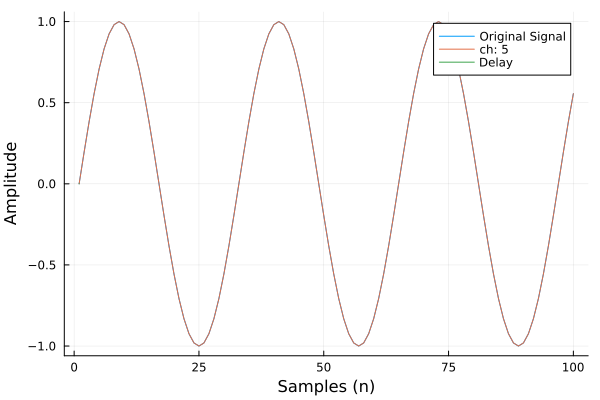

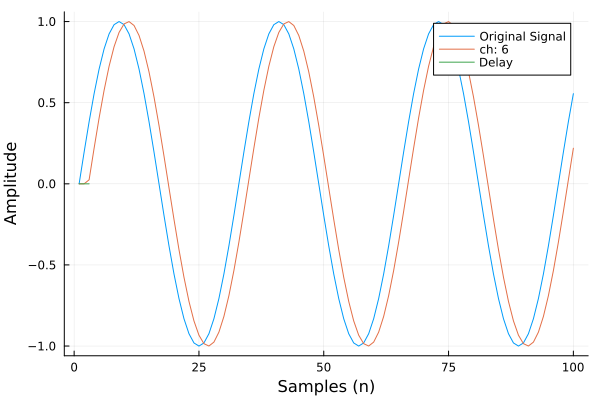

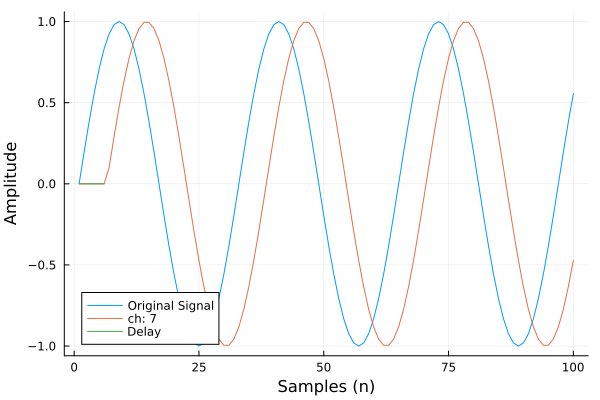

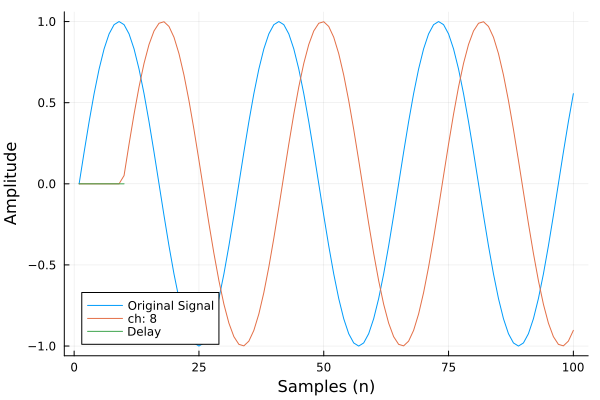

Value of d_max: 100


In [105]:
check_delayed_signal(tone_sig, real(sig2), d2, sample_rate, 10);

In [175]:
#=
Input:
signal          : Single Channel Signal
freq_interest   : Frequency of Interest (in Hz)
fs              : Sampling Rate of Signal (in Hz)
win_size        : Size of Window for STFT
noverlap        : Number of Samples Overlapping

Output:
The STFT time series of the selected Frequency of Interest
=#
# using DSP
# using DSP.Periodograms
function choose_freq(signal, freq_interest, fs=32000, win_size=2^11, noverlap=2^8, NFFT=win_size)
    S, frequencies, times = stft(signal, rect(win_size), noverlap, NFFT, fs)
    (_, freq_idx) = findmin( abs.(frequencies .- freq_interest) )

    return S[freq_idx, :]
end

function filter_freq_per_ch(new_sig, freq, sample_rate, win_size, noverlap, NFFT)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate, win_size, noverlap, NFFT);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig, freq, sample_rate, NFFT, noverlap, NFFT);
new_S1 = filter_freq_per_ch(sig1);
new_S2 = filter_freq_per_ch(sig2);

# This can be summarized in the following code:
# include("./utils/preprocess.jl")

8×311 Matrix{ComplexF64}:
     -961.708+336.035im      -966.722+337.663im  …    0.0082831-0.00540052im
     -1018.18-34.0317im      -1023.48-32.7393im      0.00347663-0.00510319im
     -753.266-691.872im      -754.193-692.648im      0.00447586+0.00663004im
     -193.553-1005.58im      -193.882-1005.48im     0.000214953-0.0011807im
 -8.02967e-12-1024.0im   -1.60745e-11-1024.0im      1.96838e-17-5.65472e-14im
     -367.094-955.612im      -368.398-955.438im  …   0.00227771-0.00436161im
     -899.796-481.881im      -902.601-483.608im       0.0126134+0.00129513im
     -1007.86+147.468im      -1013.17+148.517im      0.00715531-0.00568718im

Calculate the Covaraince

In [176]:
using Statistics
n_snapshots = 128;
Rx = cov(new_S[:,1:n_snapshots], dims=2);
#=
Equivalent Method: 
can do paranoid check by using println()
=#
Rx = (1 ./ n_snapshots) .* (new_S[:,1:n_snapshots] * (new_S[:,1:n_snapshots])');

Rx1 = cov(new_S1[:,1:n_snapshots], dims=2);
Rx2 = cov(new_S2[:,1:n_snapshots], dims=2);

@time P_cbf, az_list = cbf(Rx, sensors, freq, c0);
@time P1_cbf, az_list = cbf(Rx1, sensors, freq, c0)
@time P2_cbf, az_list = cbf(Rx2, sensors, freq, c0)

  0.000611 seconds (4.35 k allocations: 384.562 KiB)
  0.000597 seconds (4.35 k allocations: 384.562 KiB)
  0.000571 seconds (4.35 k allocations: 384.562 KiB)


([7.434456258582118e6, 7.316426247140916e6, 7.198639311523011e6, 7.081159231060692e6, 6.964048195250383e6, 6.847366762575393e6, 6.731173822877629e6, 6.6155265632667905e6, 6.500480437547871e6, 6.38608913914031e6  …  8.496417836939301e6, 8.37930760367573e6, 8.261803430831603e6, 8.143980972595129e6, 8.025914821421277e6, 7.907678435772462e6, 7.789344071131356e6, 7.670982714352248e6, 7.552664021408199e6, 7.434456258582118e6], LinRange{Float64}(-180.0, 180.0, 361))

In [177]:
P_cbf_norm, az_cbf_max = normalize_P(P_cbf, az_list)
P1_cbf_norm, az1_cbf_max = normalize_P(P1_cbf, az_list)
P2_cbf_norm, az2_cbf_max = normalize_P(P2_cbf, az_list)

([0.6112665146658587, 0.6015619994719803, 0.5918774701528098, 0.582218170692413, 0.5725892143573696, 0.5629955803111506, 0.5534421105202908, 0.5439335069514191, 0.5344743290575638, 0.5250689915515458  …  0.6985817842879107, 0.6889528939388563, 0.6792916135849353, 0.6696041635696858, 0.6598966769401502, 0.6501751935056611, 0.6404456541656633, 0.6307138955120337, 0.6209856447106064, 0.6112665146658587], 120.0)

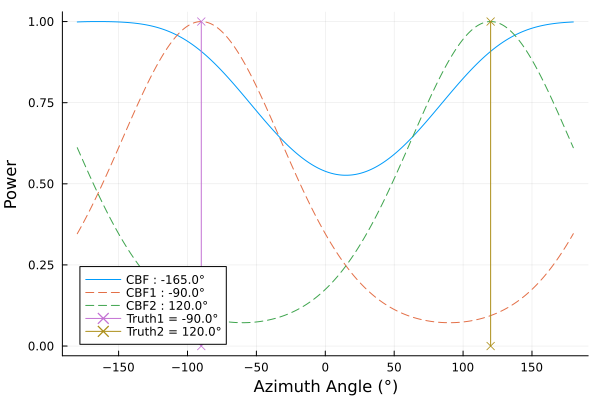

In [178]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power")
plot!(az_list, P1_cbf_norm, label="CBF1 : $(az1_cbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_cbf_norm, label="CBF2 : $(az2_cbf_max)°",
    linestyle=:dash);
plot!([az_gt1; az_gt1], [0; 1], marker=:x, label="Truth1 = $(az_gt1)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

In [179]:
order = 3;
@time P_dbf, az_list = dbf_coFree(Rx, sensors, order, freq, c0)
@time P1_dbf, az_list = dbf_coFree(Rx1, sensors, order, freq, c0)
@time P2_dbf, az_list = dbf_coFree(Rx2, sensors, order, freq, c0)

P_dbf_norm, az_dbf_max = normalize_P(P_dbf, az_list)
P1_dbf_norm, az1_dbf_max = normalize_P(P1_dbf, az_list)
P2_dbf_norm, az2_dbf_max = normalize_P(P2_dbf, az_list)

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001098 seconds (11.53 k allocations: 684.562 KiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001043 seconds (11.53 k allocations: 684.070 KiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.000961 seconds (11.53 k allocations: 685.055 KiB)


([0.0200095749600126, 0.023755741088217392, 0.027516544679652838, 0.03122389542456217, 0.03481498466141861, 0.03823265920432384, 0.041425727096697736, 0.044349194072350426, 0.04696443022367407, 0.04923926708817082  …  0.0001334822342335157, 7.683463183486725e-5, 0.0007936106453983677, 0.002194737565410673, 0.004190540359748234, 0.006691560716765736, 0.009609348855218481, 0.01285722130108369, 0.016350978289080477, 0.020009574960014088], 120.0)

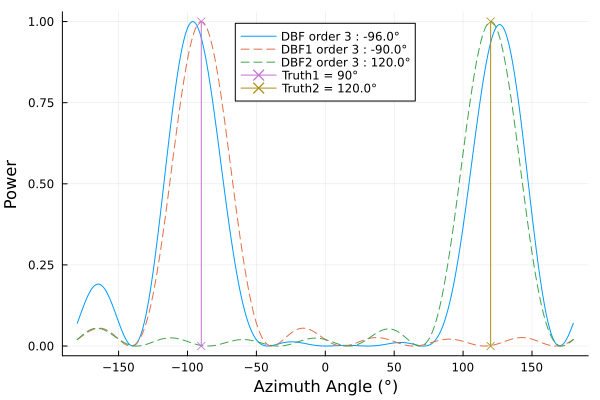

In [180]:
plot(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_dbf_norm, label="DBF1 order $order : $(az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_dbf_norm, label="DBF2 order $order : $(az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt1; az_gt1], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°", legend=:top)